<a href="https://colab.research.google.com/github/astrocyte/Accelerate/blob/master/MCSS_CR_Kmeans_Global_Centroids_0_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

base_dest_folder = "/content/drive/MyDrive/Shawn_buffer_1"  #<<********* Modify this base path as needed!!!!!!!!!!!!!!!

Mounted at /content/drive


Fraction of mixture component 0: 0.2514
Fraction of mixture component 1: 0.2456
Fraction of mixture component 2: 0.2494
Fraction of mixture component 3: 0.2536


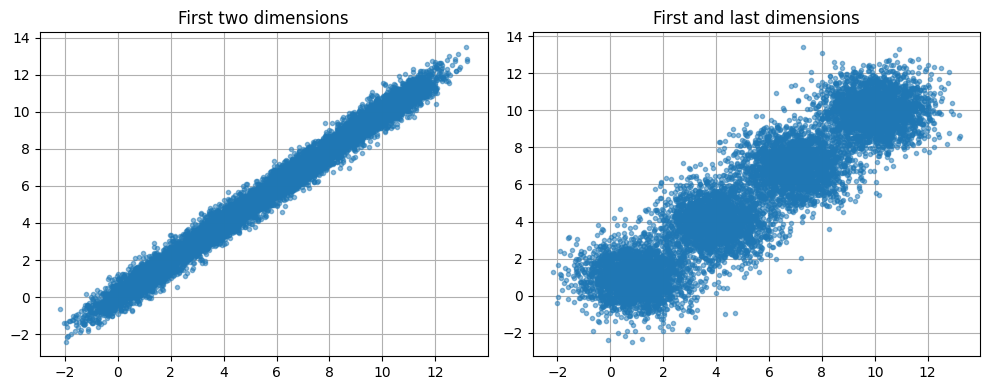

Samples saved to GaussMix4_10000_n_clusters4_samples_100_dim_base_variance_toeplitz_covariance_20250209-163346/data/samples_original_1.csv
Ground truth labels saved to GaussMix4_10000_n_clusters4_samples_100_dim_base_variance_toeplitz_covariance_20250209-163346/data/ground_truth_labels_1.csv
KMeans predicted test data saved to GaussMix4_10000_n_clusters4_samples_100_dim_base_variance_toeplitz_covariance_20250209-163346/kmeans_results/KMeans_4_clusters/kmeans_predicted_testdata_80_20_1.csv
B_idx_1 index = 0
B_idx_1 index = 1
B_idx_1 index = 2
B_idx_1 index = 3
B_idx_1 index = 4
B_idx_1 index = 5
B_idx_1 index = 6
B_idx_1 index = 7
B_idx_1 index = 8
B_idx_1 index = 9
B_idx_1 index = 10
B_idx_1 index = 11
B_idx_1 index = 12
B_idx_1 index = 13
B_idx_1 index = 14
B_idx_1 index = 15
B_idx_1 index = 16
B_idx_1 index = 17
B_idx_1 index = 18
B_idx_1 index = 19
B_idx_1 index = 20
B_idx_1 index = 21
B_idx_1 index = 22
B_idx_1 index = 23
B_idx_1 index = 24
B_idx_1 index = 25
B_idx_1 index = 26
B_i

In [2]:
import os
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from datetime import datetime

from scipy.linalg import norm, toeplitz
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans, AgglomerativeClustering

# Set seed for reproducibility
seed = 123
np.random.seed(seed)
random.seed(seed)

# Parameters
dim = 100
n = 10000
variance_setting = "base"
covariance_type = "toeplitz"  # Can be "diagonal or "toeplitz"
B = 200  # Number of Monte Carlo iterations
n_clusters_1 = 4
percent_train = 0.8
train_num_1 = int(n * percent_train)
test_num_1 = n - train_num_1

# Paths
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
save_folder = f"GaussMix4_{n}_n_clusters{n_clusters_1}_samples_{dim}_dim_{variance_setting}_variance_{covariance_type}_covariance_{timestamp}"
data_dir = os.path.join(save_folder, 'data')
os.makedirs(data_dir, exist_ok=True)
samples_full_path = os.path.join(data_dir, 'samples_original_1.csv')
gt_labels_full_path = os.path.join(data_dir, 'ground_truth_labels_1.csv')

mc_subsets_dir = os.path.join(save_folder, 'monte_carlo_subsets')

# Gaussian Mixture Parameters
mean_vectors = [
    np.ones(dim),
    4 * np.ones(dim),
    7 * np.ones(dim),
    10 * np.ones(dim)
]
weights = [0.25, 0.25, 0.25, 0.25]

# Setting Variance Scale based on variance_setting parameters
if variance_setting == 'low':
    variance_scale = 0.1
elif variance_setting == 'base':
    variance_scale = 1
elif variance_setting == "high":
    variance_scale = 10

# Setting covariance matrix based on selection
def create_covariance_matrix(dim, variance_scale, covariance_type):
    if covariance_type == "diagonal":
        return variance_scale * np.identity(dim)
    elif covariance_type == "toeplitz":
        set_Toeplitz_part1 = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.001]
        set_Toeplitz_part2 = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.001]

        set_Toeplitz_part1 += [0] * (dim - len(set_Toeplitz_part1))
        set_Toeplitz_part2 += [0] * (dim - len(set_Toeplitz_part2))

        Toeplitz_mat = toeplitz(set_Toeplitz_part1, set_Toeplitz_part2)

        # Scale the diagonal by the constant (variance_scale) if variance is to be adjusted
        Toeplitz_mat = np.diag(np.diag(Toeplitz_mat) * variance_scale) + Toeplitz_mat - np.diag(np.diag(Toeplitz_mat))

        return Toeplitz_mat
    else:
        raise ValueError("Invalid covariance_type. Use 'diagonal' or 'toeplitz'.")

covariance_matrices = [create_covariance_matrix(dim, variance_scale, covariance_type) for _ in range(4)]

def generate_samples(n, dim, mean_vectors, covariance_matrices, weights):
    samples = np.empty((n, dim))
    component_list = np.empty((n, 1))
    for i in range(n):
        component = random.choices(range(len(weights)), weights=weights)[0]
        sample = np.random.multivariate_normal(mean_vectors[component], covariance_matrices[component])
        samples[i, :] = sample
        component_list[i] = component
    return samples, component_list

def report_fractions(component_list, weights):
    for i in range(len(weights)):
        print(f'Fraction of mixture component {i}: {np.sum(component_list == i) / n}')

def visualize_samples(samples):
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.plot(samples[:, 0], samples[:, 1], '.', alpha=0.5)
    plt.title('First two dimensions')
    plt.grid()
    plt.subplot(122)
    plt.plot(samples[:, 0], samples[:, -1], '.', alpha=0.5)
    plt.title('First and last dimensions')
    plt.grid()
    plt.tight_layout()
    plt.show()

def save_samples(samples, component_list, samples_path, gt_labels_path):
    os.makedirs(os.path.dirname(samples_path), exist_ok=True)
    pd.DataFrame(samples).to_csv(samples_path, index=False, header=False)
    pd.DataFrame(component_list).to_csv(gt_labels_path, index=False, header=False)
    print(f"Samples saved to {samples_path}")
    print(f"Ground truth labels saved to {gt_labels_path}")

def monte_carlo_subsampling(samples, n, B, subset1_size, save_folder):
    """
    Perform repeated random splits of the data into two subsets.
    These subsets will be used later for assessing clustering replicability.
    Saves the indices of each split to allow reproducibility and further analysis.
    """
    all_subset1_indices = []
    all_subset2_indices = []
    all_subset1_data = []
    all_subset2_data = []

    mc_subsets_dir = os.path.join(save_folder, 'monte_carlo_subsets')
    os.makedirs(mc_subsets_dir, exist_ok=True)

    for B_idx in range(B):
        indices = random.sample(range(n), n)
        subset1_indices = indices[:subset1_size]
        subset2_indices = indices[subset1_size:]
        all_subset1_indices.append(subset1_indices)
        all_subset2_indices.append(subset2_indices)

        subset1_data = samples[subset1_indices]
        subset2_data = samples[subset2_indices]
        all_subset1_data.append(subset1_data)
        all_subset2_data.append(subset2_data)

        subset1_indices_path = os.path.join(mc_subsets_dir, f'subset1_indices_{B_idx}.csv')
        subset2_indices_path = os.path.join(mc_subsets_dir, f'subset2_indices_{B_idx}.csv')
        pd.DataFrame(subset1_indices).to_csv(subset1_indices_path, index=False, header=False)
        pd.DataFrame(subset2_indices).to_csv(subset2_indices_path, index=False, header=False)

        subset1_data_path = os.path.join(mc_subsets_dir, f'subset1_data_{B_idx}.csv')
        subset2_data_path = os.path.join(mc_subsets_dir, f'subset2_data_{B_idx}.csv')
        pd.DataFrame(subset1_data).to_csv(subset1_data_path, index=False, header=False)
        pd.DataFrame(subset2_data).to_csv(subset2_data_path, index=False, header=False)

    return all_subset1_indices, all_subset2_indices, all_subset1_data, all_subset2_data

def calculate_and_save_sorted_centroids(samples, n_clusters_1, save_folder):
    """Calculate centroids on full dataset and sort them by L2 norm"""
    # Fit KMeans on the entire dataset
    kmeans = KMeans(n_clusters=n_clusters_1, random_state=0, n_init="auto").fit(samples)
    centroid_values = kmeans.cluster_centers_

    # Compute L2 norms and sort centroids
    l2_norms = [np.linalg.norm(row) for row in centroid_values]
    rows_with_norms = list(zip(centroid_values, l2_norms))
    centroid_values_sorted = [row for row, norm in sorted(rows_with_norms, key=lambda x: x[1])]

    # Save both original and sorted centroids
    kmeans_folder = os.path.join(save_folder, 'kmeans_results', f'KMeans_{n_clusters_1}_clusters')
    os.makedirs(kmeans_folder, exist_ok=True)

    # Save original centers (like in kmeans_full_dataset_centroids_calc_1.py)
    centers_path = os.path.join(kmeans_folder, 'cluster_centers.csv')
    pd.DataFrame(centroid_values).to_csv(centers_path, index=False, header=False)

    # Save sorted centers
    sorted_centroids_path = os.path.join(kmeans_folder, 'centroid_values_sorted.csv')
    pd.DataFrame(centroid_values_sorted).to_csv(sorted_centroids_path, index=False, header=False)

    return np.array(centroid_values_sorted)

def perform_kmeans_clustering(all_train_data, all_test_data, B, n_clusters_1, save_folder):
    kmeans_predicted_matrix = np.zeros((B, len(all_test_data[0])))

    # Update the folder name to include the number of clusters
    kmeans_folder = os.path.join(save_folder, 'kmeans_results', f'KMeans_{n_clusters_1}_clusters')
    os.makedirs(kmeans_folder, exist_ok=True)

    for B_idx in range(B):
        train_data = all_train_data[B_idx]
        test_data = all_test_data[B_idx]

        kmeans = KMeans(n_clusters=n_clusters_1, random_state=0, n_init="auto").fit(train_data)
        predictions = kmeans.predict(test_data)
        kmeans_predicted_matrix[B_idx, :] = predictions

        cluster_centers_path = os.path.join(kmeans_folder, f"kmeans_cluster_centers_{B_idx}.csv")
        pd.DataFrame(kmeans.cluster_centers_).to_csv(cluster_centers_path, index=False, header=False)

        # Save matrix_data_cluster_{B_idx}.csv
        matrix_data_cluster_path = os.path.join(kmeans_folder, f"matrix_data_cluster_{B_idx}.csv")
        pd.DataFrame(predictions).to_csv(matrix_data_cluster_path, index=False, header=False)

    # Save kmeans_predicted_testdata_80_20_1.csv in the correct folder
    kmeans_predicted_file_path = os.path.join(kmeans_folder, 'kmeans_predicted_testdata_80_20_1.csv')
    pd.DataFrame(kmeans_predicted_matrix).to_csv(kmeans_predicted_file_path, index=False, header=False)
    print(f'KMeans predicted test data saved to {kmeans_predicted_file_path}')

    return kmeans_predicted_matrix

def align_cluster_identities(B, test_num_1, n_clusters_1, save_folder):
    form_80_20_matrix = np.zeros((B, test_num_1))
    kmeans_folder = os.path.join(save_folder, 'kmeans_results', f'KMeans_{n_clusters_1}_clusters')

    # Load global centroids (sorted)
    sorted_centroids_path = os.path.join(kmeans_folder, 'centroid_values_sorted.csv')
    whole_data_cluster_cent_1 = pd.read_csv(sorted_centroids_path, header=None).values

    for B_idx in range(B):
        print(f"B_idx_1 index = {B_idx}")  # Match R output format

        # Load cluster centers for this iteration
        cluster_centers_path = os.path.join(kmeans_folder, f'kmeans_cluster_centers_{B_idx}.csv')
        matrix_data_idx = pd.read_csv(cluster_centers_path, header=None).values

        # Compute distance matrix (hold_row_norm in R code)
        hold_row_norm = np.zeros((n_clusters_1, n_clusters_1))
        for i in range(n_clusters_1):
            for j in range(n_clusters_1):
                # Match R's computation exactly
                hold_row_norm[i,j] = np.sqrt(np.sum((matrix_data_idx[i] - whole_data_cluster_cent_1[j])**2))

        # Initialize mapping arrays (matching R code)
        sort_hold_row_norm = np.zeros(n_clusters_1, dtype=int)
        used_indices = np.zeros(n_clusters_1, dtype=bool)

        # Find optimal mapping ensuring each index is used only once
        for i in range(n_clusters_1):
            # Get available distances
            available_values = hold_row_norm[i, ~used_indices]
            # Get index of minimum value among available ones
            min_idx = np.argmin(available_values)
            # Convert to global index
            global_idx = np.where(~used_indices)[0][min_idx]
            # Store mapping and mark as used
            sort_hold_row_norm[i] = global_idx
            used_indices[global_idx] = True

        # Load cluster assignments
        assignments_path = os.path.join(kmeans_folder, f'matrix_data_cluster_{B_idx}.csv')
        vector_to_be_arranged_1 = pd.read_csv(assignments_path, header=None).values.flatten()

        # Transform assignments using mapping
        transformed_vector_1 = np.zeros(test_num_1)
        for test_point_idx in range(test_num_1):
            cluster_idx = int(vector_to_be_arranged_1[test_point_idx])
            transformed_vector_1[test_point_idx] = sort_hold_row_norm[cluster_idx]

        form_80_20_matrix[B_idx] = transformed_vector_1

        # Save individual aligned assignments
        aligned_path = os.path.join(kmeans_folder, f'aligned_matrix_data_cluster_{B_idx}.csv')
        pd.DataFrame(transformed_vector_1).to_csv(aligned_path, index=False, header=False)

    return form_80_20_matrix

def generate_and_save_clam_matrix(samples, all_test_indices, aligned_matrix, save_folder, n_clusters_1):
    n = samples.shape[0]
    clam_matrix = np.zeros((n, n_clusters_1))

    # Update the folder name to include the number of clusters
    kmeans_folder = os.path.join(save_folder, 'kmeans_results', f'KMeans_{n_clusters_1}_clusters')
    os.makedirs(kmeans_folder, exist_ok=True)

    # Create subfolder for individual CLAM matrices
    clam_matrices_folder = os.path.join(kmeans_folder, 'clam_matrices')
    os.makedirs(clam_matrices_folder, exist_ok=True)

    for B_idx in range(aligned_matrix.shape[0]):
        test_indices = all_test_indices[B_idx]
        for i, sample_idx in enumerate(test_indices):
            cluster_id = aligned_matrix[B_idx, i]
            clam_matrix[sample_idx, int(cluster_id)] += 1

        # Save individual CLAM matrix for each Monte Carlo iteration
        clam_filename = f'clam_{B_idx}.csv'
        clam_path = os.path.join(clam_matrices_folder, clam_filename)
        pd.DataFrame(clam_matrix).to_csv(clam_path, index=False)
        print(f"CLAM matrix for iteration {B_idx} saved to {clam_path}")

    # Save the final CLAM matrix
    final_clam_path = os.path.join(kmeans_folder, 'clam_final.csv')
    pd.DataFrame(clam_matrix).to_csv(final_clam_path, index=False)
    print(f"Final CLAM matrix saved to {final_clam_path}")

    return clam_matrix

# Main execution
samples, component_list = generate_samples(n, dim, mean_vectors, covariance_matrices, weights)
report_fractions(component_list, weights)
visualize_samples(samples)
save_samples(samples, component_list, samples_full_path, gt_labels_full_path)

all_train_indices, all_test_indices, all_train_data, all_test_data = monte_carlo_subsampling(samples, n, B, train_num_1, save_folder)

# Calculate and save sorted centroids before alignment
sorted_centroids = calculate_and_save_sorted_centroids(samples, n_clusters_1, save_folder)

# Perform kmeans clustering
kmeans_predicted_matrix = perform_kmeans_clustering(all_train_data, all_test_data, B, n_clusters_1, save_folder)

# Align cluster identities
aligned_matrix = align_cluster_identities(B, test_num_1, n_clusters_1, save_folder)

# Save aligned results
kmeans_folder = os.path.join(save_folder, 'kmeans_results', f'KMeans_{n_clusters_1}_clusters')
aligned_kmeans_file_path = os.path.join(kmeans_folder, 'kmeans_predicted_testdata_80_20_1_aligned.csv')
pd.DataFrame(aligned_matrix).to_csv(aligned_kmeans_file_path, index=False, header=False)

# Generate and save CLAM matrix
clam_matrix = generate_and_save_clam_matrix(samples, all_test_indices, aligned_matrix, save_folder, n_clusters_1)

run_info = {
    'parameters': {
        'dim': dim,
        'n': n,
        'variance_setting': variance_setting,
        'covariance_type': covariance_type,
        'B': B,
        'n_clusters_1': n_clusters_1,
        'percent_train': percent_train
    },
    'file_paths': {
        'data_dir': data_dir,
        'subset_indices_and_data': [
            {
                'subset1_indices': os.path.join(mc_subsets_dir, f'subset1_indices_{i}.csv'),
                'subset2_indices': os.path.join(mc_subsets_dir, f'subset2_indices_{i}.csv'),
                'subset1_data': os.path.join(mc_subsets_dir, f'subset1_data_{i}.csv'),
                'subset2_data': os.path.join(mc_subsets_dir, f'subset2_data_{i}.csv')
            }
            for i in range(B)
        ],
        'kmeans_results_dir': os.path.join(save_folder, 'kmeans_results')
    }
}

yaml_path = os.path.join(save_folder, 'run_info.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(run_info, f)

print(f"Run information saved to {yaml_path}")


In [ ]:
import shutil
def copy_folder_to_target(src_folder, base_dest_folder):
    # Extract the last part of the source folder's path (the folder name)
    subfolder_name = os.path.basename(src_folder.rstrip("/"))

    # Construct the full destination path by appending the subfolder name to the base destination folder
    dest_folder = os.path.join(base_dest_folder, subfolder_name)

    # Ensure the destination folder exists
    if os.path.exists(dest_folder):
        print(f"Destination folder {dest_folder} already exists. Removing and copying afresh.")
        shutil.rmtree(dest_folder)  # Remove it if it exists to avoid errors

    # Copy the entire folder and its contents
    shutil.copytree(src_folder, dest_folder)
    print(f"Copied entire folder {src_folder} to {dest_folder}")

# Define the source folder where your files are generated
src_folder = save_folder  # Your save_folder variable defined above. DO NOT CHANGE!

# Define the base target folder in Colab where you want to copy the files
base_dest_folder = "/content/drive/MyDrive/Shawn_buffer_1"  #<<********* Modify this base path as needed!!!!!!!!!!!!!!!

# Copy the source folder to the target base folder, creating a subfolder with the same name as the source folder
copy_folder_to_target(src_folder, base_dest_folder)